In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path = '../helperScripts/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
n_cells_per_cluster = 25
clone_scores = pd.read_csv(f'../extractedData/in_vivo/clone_scores_{n_cells_per_cluster}cellspercluster.csv',index_col=0)
# clone_scores = pd.read_csv('../extractedData/in_vivo/clone_scores.csv',index_col=0)
clone_scores['p_val_adj'] = clone_scores['p_val']*len(clone_scores.index)

n_rings =  25
# space_scores = pd.read_csv(f'../extractedData/space_scores_{n_rings}rings.csv',index_col=0)
space_scores = pd.read_csv(f'../extractedData/in_vivo/space_scores_{n_rings}rings_barcoded.csv',index_col=0)
space_scores['p_val_adj'] = space_scores['p_val']*len(space_scores.index)


In [3]:
space_scores

,score,p_val,p_val_adj
gene,,,
AKT1,5.017326,0.000083,0.009916
AXL,1.588657,0.052329,6.227148
BGN,1.565764,0.026498,3.153237
BIRC3,1.932631,0.007749,0.922173
BIRC5,5.217123,0.000083,0.009916
...,...,...,...
VGF,1.089140,0.296975,35.340055
WNT5A,1.205511,0.171652,20.426631
YAP1,3.192665,0.000083,0.009916


Number of genes with p-value less than 0.01 and score above 2: 37 total: 119


Text(0, 0.5, 'Ratio of real to permuted delta')

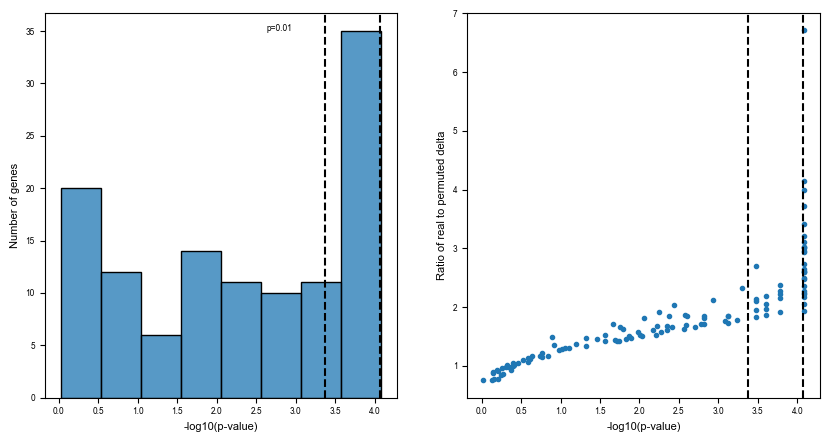

In [4]:
# plot clone scores and p-values]

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(clone_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((clone_scores['p_val'] < 0.01) & (clone_scores['score'] > 2)),'total:',len(clone_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(clone_scores['p_val']),clone_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(clone_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(clone_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

Number of genes with p-value less than 0.01 and score above 2: 63 total: 119


Text(0, 0.5, 'Ratio of real to permuted delta')

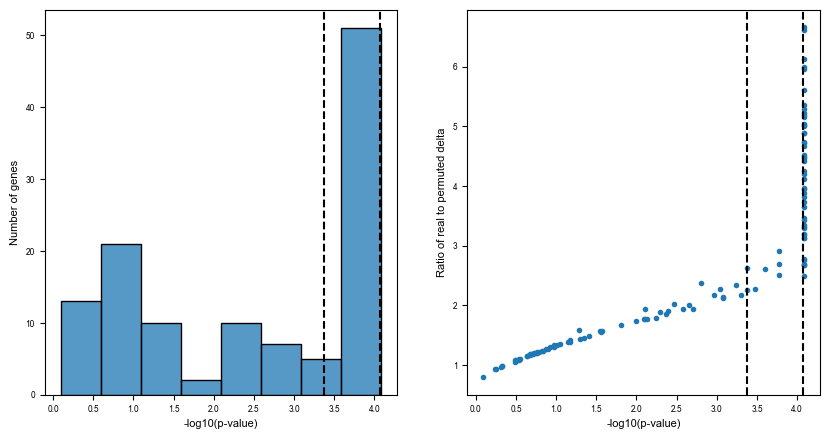

In [5]:
# plot space scores and p-values

plt.figure(figsize=(10,5))

## subplot 
plt.subplot(1,2,1)
sns.histplot(-np.log10(space_scores['p_val']))

plt.axvline(-np.log10(0.01/119),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.05/119),color='k',linestyle='--')
# plt.axvline(-np.log10(0.1),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Number of genes')

# number of genes with p-value less than 0.01 and score above 2
print('Number of genes with p-value less than 0.01 and score above 2:',np.sum((space_scores['p_val'] < 0.01) & (space_scores['score'] > 2)),'total:',len(space_scores.index))
# print()

# calculate ratio of real data to average from the permutations
plt.subplot(1,2,2)
plt.scatter(-np.log10(space_scores['p_val']),space_scores['score'],marker='.')

plt.axvline(-np.log10(0.05/len(space_scores.index)),color='k',linestyle='--')
# plt.text(-np.log10(0.01/110+0.001),35,'p=0.01',ha='right',color='k')
plt.axvline(-np.log10(0.01/len(space_scores.index)),color='k',linestyle='--')
plt.xlabel('-log10(p-value)')
plt.ylabel('Ratio of real to permuted delta')

# # annotate top genes
# for gene in clone_scores.sort_values('score',ascending=False)[:10].index:
#     plt.text(-np.log10(p_vals[gene]),scores[gene],gene,ha='right')

In [6]:
space_scores[space_scores['p_val_adj'] < 0.01]

,score,p_val,p_val_adj
gene,,,
AKT1,5.017326,0.000083,0.009916
BIRC5,5.217123,0.000083,0.009916
CALD1,4.248750,0.000083,0.009916
CAPG,4.665549,0.000083,0.009916
CCNA2,3.731672,0.000083,0.009916
CCND1,4.417487,0.000083,0.009916
CDK1,3.877159,0.000083,0.009916
CDKN1B,4.114126,0.000083,0.009916
COL1A1,4.726904,0.000083,0.009916


In [7]:
both_scores = pd.merge(clone_scores,space_scores,left_index=True,right_index=True,suffixes=('_clone','_space'))

In [8]:
both_scores[both_scores['p_val_adj_clone'] < 0.01]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,
CALD1,2.743579,0.000083,0.009916,4.248750,0.000083,0.009916
CAPG,2.178222,0.000083,0.009916,4.665549,0.000083,0.009916
CTNNB1,3.114488,0.000083,0.009916,5.193245,0.000083,0.009916
ERBB3,1.927050,0.000083,0.009916,4.203014,0.000083,0.009916
FGFR1,3.990194,0.000083,0.009916,1.098642,0.293059,34.874010
FN1,3.218143,0.000083,0.009916,3.348293,0.000083,0.009916
GFP,2.365067,0.000083,0.009916,2.264213,0.000333,0.039663
HIF1A,2.238015,0.000083,0.009916,4.894553,0.000083,0.009916
HK2,4.149223,0.000083,0.009916,4.519985,0.000083,0.009916


In [9]:
both_scores[both_scores['p_val_adj_space'] < 0.01].count()

score_clone        47
p_val_clone        47
p_val_adj_clone    47
score_space        47
p_val_space        47
p_val_adj_space    47
dtype: int64

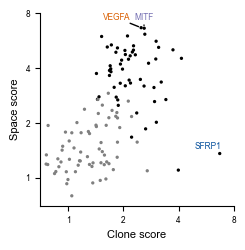

In [10]:
# plot ratio for clone and rings, only plotting genes present in both sets
# common_genes = [gene for gene in scores_ring.index if gene in scores.index]
plt.figure(figsize=(2.5,2.5))

color_list = []

score_cutoff = 2 
p_val_adj_cutoff = 0.01

# color points by p-value and score
for entry in both_scores.index:
    if both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['score_space'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff and both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff:
        color_list.append('k')
    elif both_scores['score_clone'].loc[entry] > score_cutoff and both_scores['p_val_adj_clone'].loc[entry] < p_val_adj_cutoff:
        color_list.append('k')
    elif both_scores['p_val_adj_space'].loc[entry] < p_val_adj_cutoff and both_scores['score_space'].loc[entry] > score_cutoff:
        color_list.append('k')
    else:
        color_list.append('gray')



plt.scatter(both_scores['score_clone'],both_scores['score_space'],marker='.',color=color_list,s=7.5)

plt.xlabel('Clone score\n(ratio of true difference to avg. permuted difference)')
plt.ylabel('Space score\n(ratio of true difference to avg. permuted difference)')

plt.xlabel('Clone score')
plt.ylabel('Space score')

# annotate top 5 genes for each using adjust_text

# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','ITGA8','MMP11']
# genes_to_plot = ['VEGFA','SFRP1','MITF','SPARC','MMP1','BMP2']
genes_to_plot = ['VEGFA','SFRP1','MITF',
                #  'SPARC'
                 ]
gene_colors = ['b','orange','r','k']

gene_colors = {
                # 'VEGFA':'#5e3c99',
               'VEGFA':'#d95f02', # dark orange
               'SFRP1':'#08519c', # blue
            #    'SPARC':'k',
               
            #    'MITF':'#e66101',
               'MITF':'#7570b3', # purple
               
               }




texts = []



for gene in genes_to_plot:
    texts.append(plt.text(both_scores['score_clone'].loc[gene],both_scores['score_space'].loc[gene],gene,ha='right',c=gene_colors[gene]))

# plt.axvline(2,color='k',linestyle='--',lw=1,zorder=0)
# plt.axhline(2,color='k',linestyle='--',lw=1,zorder=0) 

# plt.axvline(3,color='k',linestyle='--',lw=1,zorder=0)
# plt.axhline(3,color='k',linestyle='--',lw=1,zorder=0) 

# plt.axvline(1,color='gray',linestyle='-',lw=1,zorder=0)
# plt.axhline(1,color='gray',linestyle='-',lw=1,zorder=0) 

# plt.xlim(0.5,4)
# plt.ylim(0.5,4)

# plt.xlim(0.5,8)
# plt.ylim(0.5,8)
plt.yscale('log',base=2)
plt.xscale('log',base=2)

plt.xticks([0.5,1,2,4,8],[0.5,1,2,4,8])
plt.yticks([0.5,1,2,4,8],[0.5,1,2,4,8])

plt.xlim(0.7,8)
plt.ylim(0.7,8)

sns.despine()

# plt.xlim(0,4)
# plt.ylim(0,4)

# plt.xticks([0,1,2,3,4])
# plt.yticks([0,1,2,3,4])


# for gene in scores_ring.sort_values(ascending=False)[:5].index:
#     texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=False)[:10].index:
#     if gene not in scores_ring.sort_values(ascending=False)[:10].index:
#         texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

# for gene in scores.sort_values(ascending=True)[:10].index:
#     if gene in scores_ring.sort_values(ascending=True)[:10].index:
#         if gene != 'ENSMUSG00000071361':
#             texts.append(plt.text(scores[gene],scores_ring[gene],gene,ha='right'))

adjust_text(texts,x=both_scores['score_clone'],y=both_scores['score_space'],force_static=(2,2),arrowprops=dict(arrowstyle='-',color='k'))

plt.savefig('../graphs/clone_v_space_scores.pdf',bbox_inches='tight',transparent=True)


In [11]:
both_scores[both_scores['score_clone'] < 0.5]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,


In [12]:
both_scores[(both_scores['score_clone'] < 1.1) & (both_scores['score_space'] > 1.1)]

,score_clone,p_val_clone,p_val_adj_clone,score_space,p_val_space,p_val_adj_space
gene,,,,,,
AXL,1.011675,0.385718,45.900425,1.588657,0.052329,6.227148
BIRC3,0.776023,0.699192,83.203816,1.932631,0.007749,0.922173
BMP4,0.932243,0.645446,76.808099,1.485674,0.038663,4.600950
KIT,0.877353,0.718690,85.524123,1.266873,0.127406,15.161320
MERTK,0.965253,0.548538,65.275977,1.777187,0.007416,0.882510
MMP11,0.912489,0.623948,74.249813,1.218025,0.170986,20.347304
NANOG,1.014654,0.478710,56.966503,1.259600,0.134322,15.984335
NGFR,0.925529,0.418215,49.767603,1.414480,0.067244,8.002083
OASL,0.772293,0.621865,74.001917,1.179027,0.209149,24.888759
